# Projet Marion

### DATA LOADING

Ouvrir les datas, les classés entre trainings, tests, et validation
Regarder pour créer un sous-set de data pour pouvoir run sur notre ordi (voir avec Théo)

/opt/miniconda3/envs/hurricane/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/miniconda3/envs/hurricane/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /opt/miniconda3/envs/hurricane/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/miniconda3/envs/hurricane/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/miniconda3/envs/hurricane/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/miniconda3/envs/hurricane/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/miniconda3/envs/hurricane/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environm

Device utilisé : cpu
Classes : ['damage', 'no_damage']
Nombre d'images (train) : 19000 , utilisé : 200
Nombre d'images (val) : 2000 , utilisé : 100
Nombre d'images (test) : 2000 , utilisé : 100


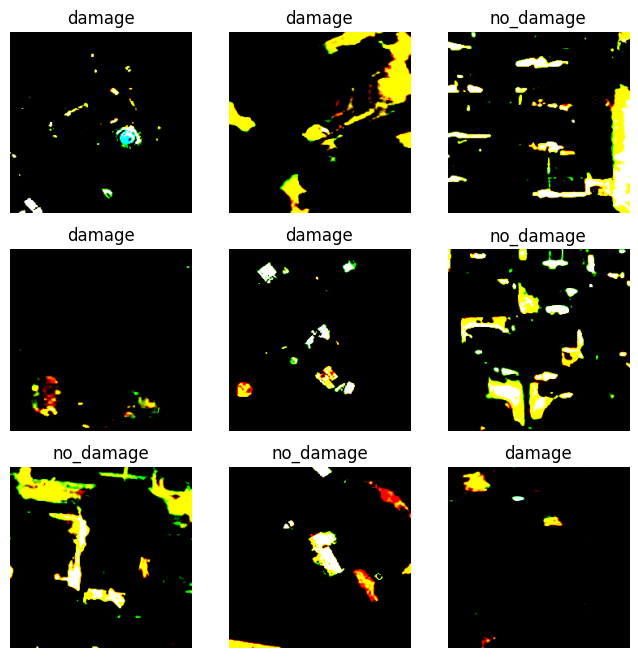

In [1]:
import os
import random
from collections import defaultdict

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

base_dir = "ipeo_hurricane_for_students"

from UCMerced_module import default_transform, unnormalize

# J'utilise default_transform qui vient de la fonction du prof, mais peut-être à modifier

train_ds = datasets.ImageFolder(os.path.join(base_dir, "train"), transform=default_transform)
val_ds   = datasets.ImageFolder(os.path.join(base_dir, "validation"), transform=default_transform)
test_ds  = datasets.ImageFolder(os.path.join(base_dir, "test"), transform=default_transform)

### PARTIE À ENLEVER DANS LA VERSION FINALE ###
# Détection du device (GPU si disponible, sinon CPU), à enlever dans la version finale
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device utilisé :", device)

# Option pour utiliser un subset stratifié (True) ou l'ensemble complet (False), à enlever dans la version finale
use_subset = True  # <- change this ligne pour True/False
samples_per_class = 100  # nombre d'images par classe dans le subset (ajuste selon besoin)
seed = 42


# à enlever dans la version finale
def make_stratified_subset(imagefolder_dataset, samples_per_class=100, seed=42):
    """Retourne un torch.utils.data.Subset stratifié par classe (max samples_per_class par classe)."""
    random.seed(seed)
    class_indices = defaultdict(list)
    # ImageFolder stocke les couples (path, class) dans .samples
    for idx, (path, label) in enumerate(imagefolder_dataset.samples):
        class_indices[label].append(idx)
    selected = []
    for label, indices in class_indices.items():
        k = min(len(indices), samples_per_class)
        if k > 0:
            selected.extend(random.sample(indices, k))
    return Subset(imagefolder_dataset, selected)

# Créer les datasets à utiliser (subset ou full) => ça sera à enlever pour le training final, c'est juste pour avoir une idée
if use_subset:
    small_train_ds = make_stratified_subset(train_ds, samples_per_class=samples_per_class, seed=seed)
    small_val_ds = make_stratified_subset(val_ds, samples_per_class=min(50, samples_per_class), seed=seed+1)
    small_test_ds = make_stratified_subset(test_ds, samples_per_class=min(50, samples_per_class), seed=seed+2)
    train_dataset = small_train_ds
    val_dataset = small_val_ds
    test_dataset = small_test_ds
else:
    train_dataset = train_ds
    val_dataset = val_ds
    test_dataset = test_ds

### FIN PARTIE À ENLEVER ###

# Ajustements DataLoader pour CPU (si pas de GPU) : réduire batch_size si besoin, num_workers=0 sur macOS (2 dans le cours)
# à voir si on garde ça comme ça
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, num_workers=0, pin_memory=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, num_workers=0, pin_memory=False)


print("Classes :", train_ds.classes)
print("Nombre d'images (train) :", len(train_ds), ", utilisé :", len(train_dataset))
print("Nombre d'images (val) :", len(val_ds), ", utilisé :", len(val_dataset))
print("Nombre d'images (test) :", len(test_ds), ", utilisé :", len(test_dataset))


def show_batch(loader):
    images, labels = next(iter(loader))
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    for img, label, ax in zip(images[:9], labels[:9], axes.flat):
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(train_ds.classes[label])
        ax.axis("off")
    plt.show()

show_batch(train_loader)


Loading of Computer Vision Model

In [16]:
from torch import nn
# solution
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [6]:
from torchvision.models import resnet34, mobilenet_v3_small


# load a resnet34 with 21 classes and move to device
model_resnet = resnet34(num_classes=21).to(device)
model_resnet

# load a mobilnet_v3_small with 21 classes and move to device
model_mobilenet = mobilenet_v3_small(num_classes=21).to(device)
model_mobilenet


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

## Loss function

In [7]:
from torch.nn import CrossEntropyLoss

criterion = CrossEntropyLoss()

## Optimizer

In [8]:
from torch.optim import SGD

learning_rate = 0.01

optimizer_resnet = SGD(model_resnet.parameters(),lr=learning_rate)
optimizer_mobilenet = SGD(model_mobilenet.parameters(),lr=learning_rate)

## Test training du model resnet

In [9]:
import torch.nn.functional as F

def training_step(batch, model, optimizer, device):
    model.train()
    optimizer.zero_grad()

    x, y = batch
    x = x.to(device)
    y = y.to(device)

    y_hat = model(x)
    loss = criterion(y_hat, y)

    loss.backward()
    optimizer.step()

    preds = y_hat.argmax(1).cpu().detach().numpy()
    gt = y.cpu().detach().numpy()
    accuracy = (preds == gt).mean()

    return loss.item(), float(accuracy)


### Test sans GPU

In [11]:
print(device)
idx, batch = next(enumerate(train_loader))
%timeit training_step(batch, model_mobilenet, optimizer_mobilenet, device=device)
%timeit training_step(batch, model_resnet, optimizer_resnet, device=device)

cpu
874 ms ± 1.62 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.17 s ± 8.98 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Training sur tous les batchs

In [12]:
import numpy as np

def train_epoch(train_dl, model, optimizer, device):

    # collect some statistics
    losses, accuracies = [], []

    for batch in train_dl:
        loss, accuracy = training_step(batch, model, optimizer, device)

        # append statistics (loss is a float already)
        losses.append(loss)
        accuracies.append(accuracy)

    # protections si listes vides
    if len(losses) == 0:
        return 0.0, 0.0

    # return averaged losses and accuracies
    return float(np.mean(losses)), float(np.mean(accuracies))


def validate_epoch(val_dl, model, device):
    """Évalue le modèle sur l'ensemble de validation (sans backprop)."""
    model.eval()
    losses, accuracies = [], []

    with torch.no_grad():  # pas de gradient pour la validation
        for batch in val_dl:
            x, y = batch
            x = x.to(device)
            y = y.to(device)

            y_hat = model(x)
            loss = criterion(y_hat, y)

            preds = y_hat.argmax(1).cpu().detach().numpy()
            gt = y.cpu().detach().numpy()
            accuracy = (preds == gt).mean()

            losses.append(loss.item())
            accuracies.append(accuracy)

    if len(losses) == 0:
        return 0.0, 0.0

    return float(np.mean(losses)), float(np.mean(accuracies))


In [17]:
num_epochs = 30

stats_mobilenet = []
for epoch in range(num_epochs):
    trainloss_mobilenet, trainaccuracy_mobilenet = train_epoch(train_loader, model_mobilenet, optimizer_mobilenet, device)
    valloss_mobilenet, valaccuracy_mobilenet = validate_epoch(val_loader, model_mobilenet, device)

    print(f"epoch {epoch}; trainloss {trainloss_mobilenet:.4f}, train accuracy {trainaccuracy_mobilenet*100:.2f}% | valloss {valloss_mobilenet:.4f}, val accuracy {valaccuracy_mobilenet*100:.2f}%")

    stats_mobilenet.append({
        "trainloss": float(trainloss_mobilenet),
        "trainaccuracy": float(trainaccuracy_mobilenet),
        "valloss": float(valloss_mobilenet),
        "valaccuracy": float(valaccuracy_mobilenet),
        "epoch": epoch
    })

stats_resnet = []
for epoch in range(num_epochs):
    trainloss_resnet, trainaccuracy_resnet = train_epoch(train_loader, model_resnet, optimizer_resnet, device)
    valloss_resnet, valaccuracy_resnet = validate_epoch(val_loader, model_resnet, device)

    print(f"epoch {epoch}; trainloss {trainloss_resnet:.4f}, train accuracy {trainaccuracy_resnet*100:.2f}% | valloss {valloss_resnet:.4f}, val accuracy {valaccuracy_resnet*100:.2f}%")

    stats_resnet.append({
        "trainloss": float(trainloss_resnet),
        "trainaccuracy": float(trainaccuracy_resnet),
        "valloss": float(valloss_resnet),
        "valaccuracy": float(valaccuracy_resnet),
        "epoch": epoch
    })


epoch 0; trainloss 2.1461, train accuracy 77.88% | valloss 2.5850, val accuracy 44.64%
epoch 1; trainloss 1.9614, train accuracy 77.40% | valloss 2.5247, val accuracy 44.64%
epoch 2; trainloss 1.7988, train accuracy 77.40% | valloss 2.4626, val accuracy 44.64%
epoch 3; trainloss 1.5608, train accuracy 78.37% | valloss 2.3984, val accuracy 44.64%
epoch 4; trainloss 1.3453, train accuracy 81.25% | valloss 2.3321, val accuracy 44.64%
epoch 5; trainloss 1.1151, train accuracy 82.21% | valloss 2.2681, val accuracy 44.64%
epoch 6; trainloss 0.8890, train accuracy 86.54% | valloss 2.2072, val accuracy 44.64%
epoch 7; trainloss 0.7222, train accuracy 87.98% | valloss 2.1503, val accuracy 44.64%
epoch 8; trainloss 0.6002, train accuracy 87.02% | valloss 2.0990, val accuracy 44.64%
epoch 9; trainloss 0.4308, train accuracy 92.31% | valloss 2.0518, val accuracy 44.64%
epoch 10; trainloss 0.3516, train accuracy 93.75% | valloss 2.0120, val accuracy 44.64%
epoch 11; trainloss 0.2948, train accuracy

### Visualisation des erreurs pour mobilenet

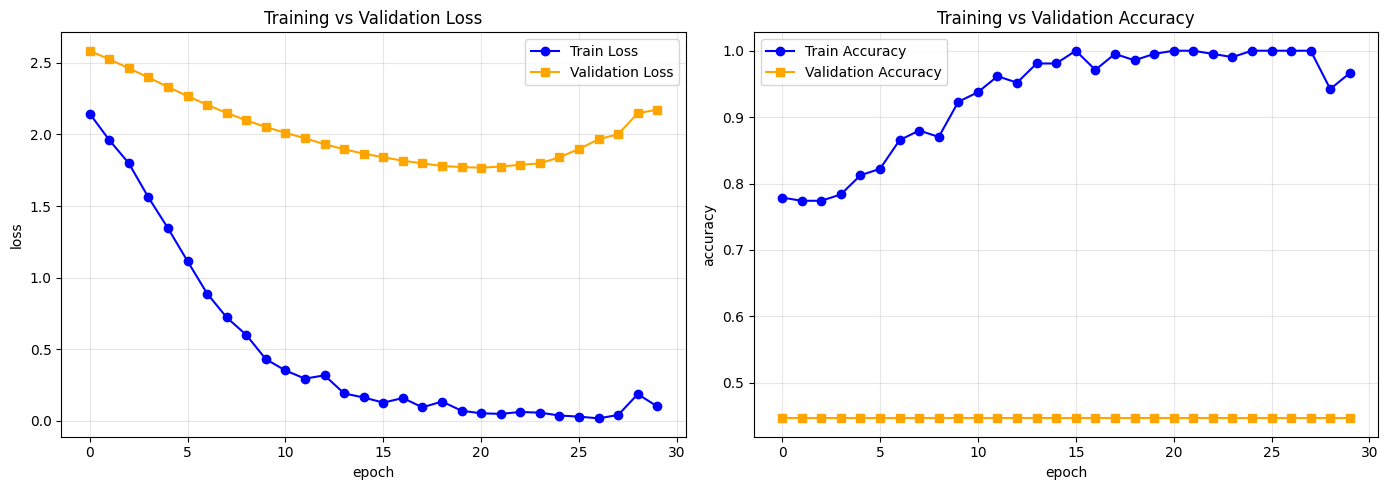

In [18]:
trainlosses = np.array([stat["trainloss"] for stat in stats_mobilenet])
trainaccuracy = np.array([stat["trainaccuracy"] for stat in stats_mobilenet])
vallosses = np.array([stat["valloss"] for stat in stats_mobilenet])
valaccuracy = np.array([stat["valaccuracy"] for stat in stats_mobilenet])
epochs = np.array([stat["epoch"] for stat in stats_mobilenet])
# Créer une figure avec 2 subplots (loss et accuracy)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Subplot 1 : Loss (train + validation)
ax1.plot(epochs, trainlosses, marker='o', label='Train Loss', color='blue')
ax1.plot(epochs, vallosses, marker='s', label='Validation Loss', color='orange')
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
ax1.set_title("Training vs Validation Loss")
ax1.grid(True, alpha=0.3)
ax1.legend()

# Subplot 2 : Accuracy (train + validation)
ax2.plot(epochs, trainaccuracy, marker='o', label='Train Accuracy', color='blue')
ax2.plot(epochs, valaccuracy, marker='s', label='Validation Accuracy', color='orange')
ax2.set_xlabel("epoch")
ax2.set_ylabel("accuracy")
ax2.set_title("Training vs Validation Accuracy")
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()


### Visualisations des erreurs pour resnet

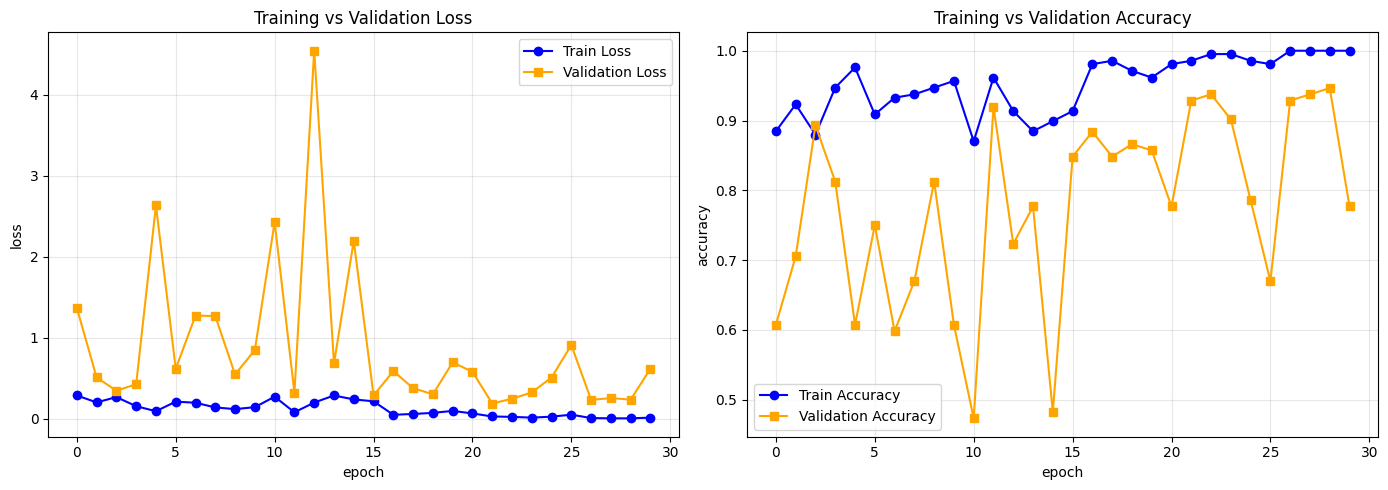

In [19]:
trainlosses = np.array([stat["trainloss"] for stat in stats_resnet])
trainaccuracy = np.array([stat["trainaccuracy"] for stat in stats_resnet])
vallosses = np.array([stat["valloss"] for stat in stats_resnet])
valaccuracy = np.array([stat["valaccuracy"] for stat in stats_resnet])
epochs = np.array([stat["epoch"] for stat in stats_resnet])
# Créer une figure avec 2 subplots (loss et accuracy)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Subplot 1 : Loss (train + validation)
ax1.plot(epochs, trainlosses, marker='o', label='Train Loss', color='blue')
ax1.plot(epochs, vallosses, marker='s', label='Validation Loss', color='orange')
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
ax1.set_title("Training vs Validation Loss")
ax1.grid(True, alpha=0.3)
ax1.legend()

# Subplot 2 : Accuracy (train + validation)
ax2.plot(epochs, trainaccuracy, marker='o', label='Train Accuracy', color='blue')
ax2.plot(epochs, valaccuracy, marker='s', label='Validation Accuracy', color='orange')
ax2.set_xlabel("epoch")
ax2.set_ylabel("accuracy")
ax2.set_title("Training vs Validation Accuracy")
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

## Idée pour la data augmentation

Pour l'instant j'utilise default_transform du cours, mais je peux faire un truc un peu plus tricky, et aussi faudrait gérer le problème des datas unbalanced